## Introduction to the Multilayer Perceptron (MLP)

### Motivation: Limitations of Logistic regression

LR is a very powerful and simple to use tool, however it has its limitations.
* It can only perform linear classification
* Therefore is not useful to classificate complex relationships

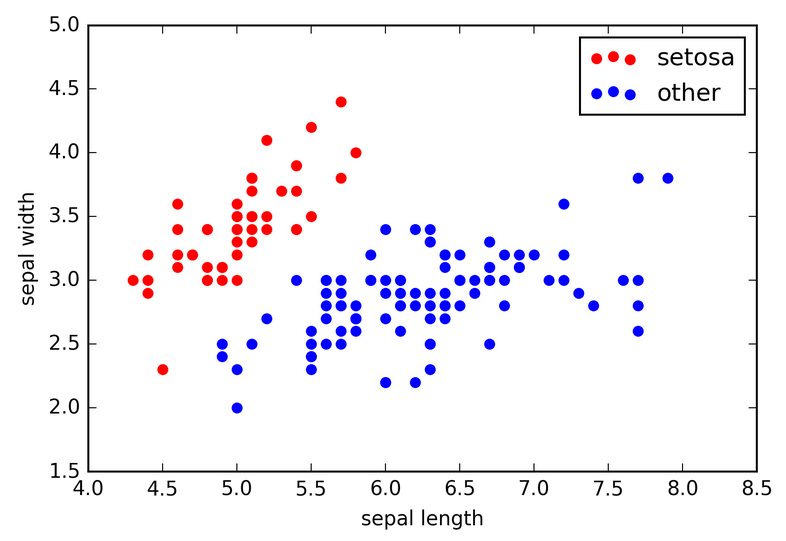
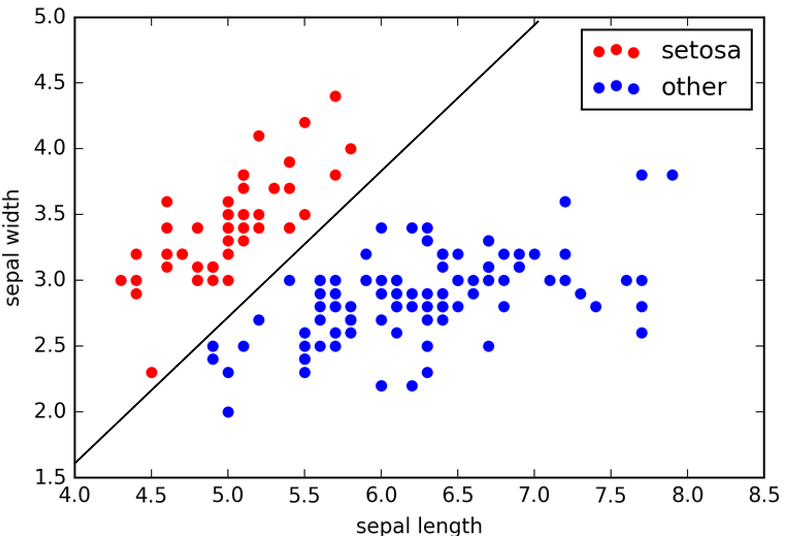

Image recovered from: https://www.mathematik.uni-muenchen.de/~deckert/teaching/SS18/sec-steps.html

### Solution

The solution was to introduce the MLP, which is an extension of the logistic regression. 
It is called deep learning because by having several layers we add depth to the network, which increase the complexity of the model.

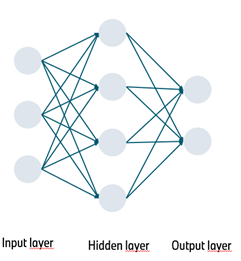

In simple words consist in creating several logistic regression models, where the output of the input model, goes to the input of the hidden layer model.
It is possible to use more than one hidden layer, deppending on the complexity of the problem

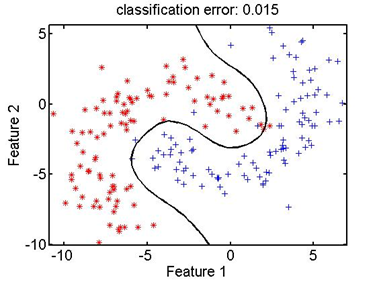

### Note: NN connections

Until now all the connections used in our neural networks are feed forward (from input layer in direction to the output layer), but note that doing lateral or recurrent connections is also possible

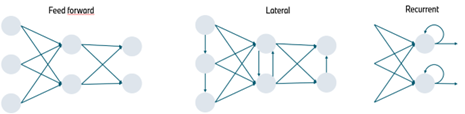

## Practice

Continuing the problem of the MNIST data set classification, a MLP will be implemented to improve the model

In [ ]:
import torch
import torchvision
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

### Step 1. Prepare the data

In [ ]:
# Same as last session.
batch_size = 100

def split_idxs(set_size, percentage):
    # Size of validation data set
    val_size = int(percentage*set_size)
    # Create a random permutation of 0 to n-1
    idxs = np.random.permutation(set_size)
    # Pick first val_size indices for validation set
    return idxs[:val_size], idxs[val_size:]  # validation set idxs, training set idxs

# No necessary to download
dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_set = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

val_idxs, train_idxs = split_idxs(len(dataset), 0.2)

train_sampler = SubsetRandomSampler(train_idxs) 
train_loader = DataLoader(dataset, batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_idxs)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

### Define the model

In [ ]:
class MNIST_MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Hidden layer
        self.linear1 = nn.Linear(input_size, hidden_size)
        # Output layer
        self.linear2 = nn.Linear(hidden_size, output_size)
        
#     def __init__(self, input_size, hidden_size, hidden_size2, output_size):
#         super().__init__()
#         # 1st Hidden layer
#         self.linear1 = nn.Linear(input_size, hidden_size)
#         # 2nd Hidden layer
#         self.linear2 = nn.Linear(hidden_size, hidden_size2)
#         # Output layer
#         self.linear3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = x.view(x.size(0),-1)
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        return out

In [ ]:
input_size = 28*28
num_classes = 10

model = MNIST_MLP(input_size, hidden_size=32, output_size=num_classes)


### Helper functions

In [ ]:
def loss_batch(model, loss_fn, x, y, optimizer=None, metric=None):
    # Calculate loss
    # Step 2. Generate predictions
    predictions = model(x)
    # Step 3. Calculate the loss.
    loss = loss_fn(predictions, y)
    
    if optimizer is not None:
        # Compute gradients
        # Step 3.
        loss.backward()
        # Update parameters
        # Step 4.
        optimizer.step()
        # Reset gradients
        # Step 5.
        optimizer.zero_grad()
        
    metric_result=None
    if metric is not None:
        metric_result = metric(predictions, y)
        
    return loss.item(), len(x), metric_result


def evaluate(model, loss_fn, val_loader, metric=None):
    with torch.no_grad():
        # Pass each validation batch through the model
        results = [loss_batch(model, loss_fn, x, y, metric=metric) for x, y in val_loader]
        
        # Unzip
        losses, elements, metrics = zip(*results)
        # Total size of the data set
        total = np.sum(elements)
        # Average loss
        avg_loss = np.sum(np.multiply(losses, elements)) / total
        # Avg metric
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, elements)) / total
        return avg_loss, total, avg_metric
    
    
def accuracy(outputs, labels):
    _, predictions = torch.max(outputs, dim=1)
    return torch.sum(predictions == labels).item() / len(predictions)


def fit(epochs, lr, model, loss_fn, train_loader, val_loader, optimizer=None, metric=None):
    if optimizer is None:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        for x, y in train_loader:
            loss,_,_ = loss_batch(model, loss_fn, x, y, optimizer)
        # Evaluation per epoch
        result = evaluate(model, loss_fn, val_loader, metric)
        val_loss, total, val_metric = result
        
        # Print eval
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, epochs, val_loss, val_metric))

In [ ]:
# Train the model

fit(10, 0.1, model, F.cross_entropy, train_loader, val_loader, metric=accuracy)

## Using GPU

Follow the next steps is necessary if the advantages of GPU optimization are to be used

In [ ]:
# Step 1: Check if GPU is available
torch.cuda.is_available()

In [ ]:
# Step 2. Select device

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
print(device)

In [ ]:
# Step 3. Move data and model to device

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Wrapper to move data to a device
class DeviceDataLoader():
    def __init__(self, data_loader, device):
        self.dl = data_loader
        self.device = device
        
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)
            
    def __len__(self):
        return(len.dl)
    
# Pass our data loaders to GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [ ]:
# Train using GPU

model2 = MNIST_MLP(input_size, hidden_size=32, output_size=num_classes)
to_device(model, device)

fit(12,0.2,model2, F.cross_entropy, train_dl, val_dl, metric=accuracy)
fit(5, 0.1, model2, F.cross_entropy, train_dl, val_dl, metric=accuracy)

In [ ]:
# Test

# Expected accuracy: 97%
test_loader = DataLoader(test_set, batch_size)
result = evaluate(model2, F.cross_entropy, test_loader, accuracy)
result